## Sequence models for text classification
<hr>

1. load, split, and preprocess data 
2. define network structure, set hyper-params, compile  
3. train classifier 
4. generate predictions on holdout set 
5. evaluate performance 
6. Appendix: transfer learning with pre-trained word embeddings
  - 6.1 load pre-trained embeddings
  - 6.2 tokenize and matricize text data (replace tokens with their embeddings)
  - 6.3 adapt network structure for input matrices 
  - 6.4 train classifier, generate predictions, evaluate performance 


**`TODO`**:
- clean up all cells
- add notes where nec
- reintroduce plotting part at end

**`TODO`** -- insert discussion about:
- difference btwn sequence models + dtm-based models
- feature "learning" versus engineering
- notable hypers that dont appear in other situations
- role of embeddings + decisions to make w.r.t. them in seq mods
- decide whether to have separate rnn/gru/lstm nb's or just mention each

### 1. Load, split, and preprocess data
<hr>

Here we read in the movie reviews dataset `imdb_decoded.csv`, displaying the first few rows. Note that it has a field for train/test (`'subset'`), to make splitting the data easier. Note also that it has fields `'length'` and `'length_bin'`, which specify the length (in words) and length quartile the review belongs to (quartiles calculated across all 50k reviews). 

> Note: The data in `dat` is a re-formatted version of the IMDB movie reviews sentiment dataset, which can be accessed in integer-encoded format via `keras.datasets.load_imdb()`. If you don't have the file `imdb_decoded.csv`, just run the script `expt1_prep_imdb_data.py` to generate it (make sure `outfile` points to a valid filepath). 

<!-- 
  `dat` differs from the value of `keras.datasets.load_imdb()` only in format and encoding: the present version is a single rectangular data frame, the reviews have been re-encoded as English text, each review's length (in words) and train/test status is available, and the length quartile of each review is also available (in the `length_bin` field, which has values in `[0,1,2,3,4]`). 
-->

In [1]:
import pandas as pd

fname = '../experiments/expt1/data/imdb_decoded.csv'

dat = pd.read_csv(fname)
dat.head(5)

,subset,length,length_bin,label,text
0,train,217,2,1,this film was just brilliant casting location ...
1,train,188,2,0,big hair big boobs bad music and a giant safet...
2,train,140,1,0,this has to be one of the worst films of the 1...
3,train,549,3,1,the scots excel at storytelling the traditiona...
4,train,146,1,0,worst mistake of my life br br i picked this m...


There are 25k train reviews and 25k test reviews. Average review length is approximately the same across train and test subsets. 

In [2]:
train, test = dat[dat.subset=='train'], dat[dat.subset=='test']

txt_train, y_train = list(train.text), list(train.label)
txt_test, y_test = list(test.text), list(test.label)

print(f'train size: {len(txt_train)} (avg {round(train.length.mean())} words)')
print(f'test size: {len(txt_test)} (avg {round(test.length.mean())} words)')

train size: 25000 (avg 238 words)
test size: 25000 (avg 230 words)


Here we tokenize the texts, restricting vocabulary to the words appearing in the train subset. To reduce the risk of learning useless patterns from rare words, vocabulary is also restricted to the `max_features` most frequent words (within the train set). 

Because we will be learning feature representations instead of engineering them, each review must have a uniform length. To achieve this, reviews longer than `maxlen` tokens are truncated to the first `maxlen` tokens, and reviews shorter than `maxlen` tokens are left-padded with the dummy token `TODO--WHA IS PAD CHAR??` until they are `maxlen`-many tokens long. 

In [3]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


# set text-related hyper params 
maxlen = 150
max_features = 10000


# instantiate Tokenizer class (`num_words` to restrict vocab size)
# extract vocab and count words (makes several attrs available)
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(txt_train)

# integer encode the docs
x_train = tokenizer.texts_to_sequences(txt_train)
x_test = tokenizer.texts_to_sequences(txt_test)

# pad the sequences (default params `padding='pre', truncating='pre'`)
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

Using TensorFlow backend.


> Note: It is sometimes also necessary to vectorize the labels in preparation for working with neural networks. But in the present case, we are doing binary classification so a single value (`0` or `1`) is fine. If we were predicting number of stars instead of positive/negative, then we would one-hot encode each label so that e.g. `'2 stars'` would be encoded as `[0, 1, 0, 0, 0]`, `'4 stars'` would be encoded as `[0, 0, 0, 1, 0]`, and so on. 

### 2. Define network structure, set hyper-params, compile
<hr>

Here we define the network structure and *compile* the network. 

Note that the structure and definition of a network makes no reference to the data, other than that the input dimension of the input layer must be compatible with the shape of the data, and that the output layer must produce a value that makes sense in the context of the labels (in the network defined here, the output layer produces a single probability, which makes sense since we are doing binary classification). 


##### Network structure
There are infinitely many structures we could choose for a neural net-based classifier. The best structure depends on a huge number of factors, some related to the data (e.g. binary/multi-class, text or numeric input, sequence or non), some related to practical considerations (e.g. performance for real-time systems), and so on. 

Every neural network has an *input layer* and an *output layer*, but there can be any number of hidden layers between the input and output. Hidden layers can have varying numbers of nodes, the connections between the nodes can vary, and layers can be endowed with special properties like dropout. The interested reader is referred to [Chollet (2018)](TODO--link-to-DLwP) for more information. 

Here we will define a network with the following components: 

- **input layer** -- an embedding layer with input dimension `max_features` (one node for each vocabulary item) and output dimension `hidden_dim` (a tunable hyper-parameter)
- **hidden layer 1** -- an LSTM layer with dropout and recurrent dropout (these values can also be tuned), input and output dimensions are both `hidden_dim` 
- **output layer** -- a one-unit output layer with activation function `out_activation` (produces probabilities) 

##### Compiling a network
Whereas the layers and nodes of a network can be characterized mathematically, compiling a network is something that's only necessary because the network has been specified using a computer. 

Compiling the network configures it for training, by supplying information about how performance should be measured (loss, optimizer) and which algorithm should be used for optimizing the parameter weights (optimizer). 

In [4]:
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM


# training-related hypers (how much data and for how long)
epochs = 5
batch_size = 256

# training-related hypers (objective and how to maximize it)
loss = 'binary_crossentropy'
metrics = ['accuracy']
optimizer = 'adam'

# hypers for network layout + structure  
hidden_dim = 100
rec_dropout = 0.2
lstm_dropout = 0.2
out_activation = 'sigmoid'


# define the network structure 
model = Sequential()
model.add(Embedding(max_features, hidden_dim))
model.add(LSTM(hidden_dim, dropout=lstm_dropout,recurrent_dropout=rec_dropout))
model.add(Dense(1, activation=out_activation))

# compile the network 
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

Model objects of class `keras.models.Sequential` have a `.summary()` method, which you can call to see some basic info about the layers of your network, their shapes, and the number of trainable parameters they contribute to the overall model. 

In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 1,080,501
Trainable params: 1,080,501
Non-trainable params: 0
_________________________________________________________________


### 3. Train classifier 
<hr>

Here we will train the classifier in mini-batches of `batch_size`, for `epochs`-many runs through the entire dataset. Higher values for `epoch` are more likely to over-fit to the training data. 

Note also that when we specify `validation_split`, a portion of the data is not used for training, but rather to quantify the model's out-of-sample prediction accuracy. At each epoch, you will see the model's prediction accuracy on a (`valset_prop`\*100)% subset of the samples in `x_train` -- none of which is seen during actual training. 

Setting aside a portion of the training data for evaluation *during training* is important because it gives you an idea of how well your mode will generalize to cases outside of the data it was trained on. 

Crucially, the data set aside for validation during training is *not* the same as the test set (here, `x_test` and `y_test`). The test set is meant to quantify performance on a tuned/optimized model, and should be used sparingly (ideally, only once "the official model" has been selected). Instead, assess the impact of parameter tweaks by looking at how the validation accuracy changes over epochs. 

In [6]:
# prop to set aside for accuracy calc after each epoch 
valset_prop = .40

# train the model (returns a keras.callbacks.History object)
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs, validation_split=valset_prop)

Train on 15000 samples, validate on 10000 samples
Epoch 1/5
15000/15000 [==============================] - 79s 5ms/step - loss: 0.6015 - acc: 0.6889 - val_loss: 0.4496 - val_acc: 0.8062
Epoch 2/5
15000/15000 [==============================] - 64s 4ms/step - loss: 0.3558 - acc: 0.8579 - val_loss: 0.3870 - val_acc: 0.8292
Epoch 3/5
15000/15000 [==============================] - 84s 6ms/step - loss: 0.2758 - acc: 0.8935 - val_loss: 0.3589 - val_acc: 0.8578
Epoch 4/5
15000/15000 [==============================] - 74s 5ms/step - loss: 0.2408 - acc: 0.9081 - val_loss: 0.3945 - val_acc: 0.8483
Epoch 5/5
15000/15000 [==============================] - 75s 5ms/step - loss: 0.1981 - acc: 0.9276 - val_loss: 0.4120 - val_acc: 0.8428


We can also plot the accuracy and loss curves, to see how validation performance compares to training performance across training epochs. 

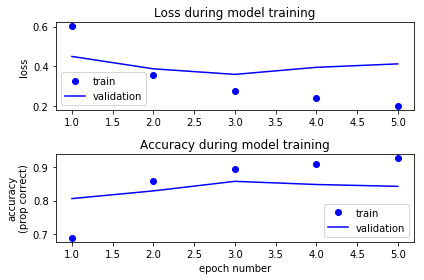

In [7]:
%matplotlib inline

from plotting_util import plot_keras_loss_accuracy_curves

### TODO: spruce up the plots (cant even see w dark jlab theme...)
plot_keras_loss_accuracy_curves(history)

### 4. Generate predictions on holdout set 
<hr>

We can now generate model predictions on the test set using the model's `.predict()` method. 

Even though the model was trained for binary classification, `model.predict()` will return a probability in [0, 1] when given a piece of text as input. This should be interpreted as the probability that the sample belongs to the positive class ("positive" in the sense of "corresponding to the value `1`"). 

Here, we simply flatten the probabilities so that values .5 and above are assigned `True` (positive sentiment), and values below .5 are assigned `False` (negative sentiment). 

> Note: We could just as easily have used the method `model.predict_classes()`, which would give us the binary predictions directly. But it can be informative to have the intermediate, probabilistic predictions if you want to introspect about why the model makes the predictions it does. 

In [8]:
# model.predict() method returns probabilities 
# (use `model.predict_classes(x_test)` to get pre-flattened categorical preds)
preds_test = model.predict(x_test)
preds_test_bool = [bool(pred >= .5) for pred in preds_test]

### 5. Evaluate model performance 
<hr>

The accuracy of a machine learning model can be evaluated in many ways. Model evaluation is no different for neural networks than it is for any other class of model: we compare our model predictions on holdout data to the actual labels/ground truth on those same data points, summarizing the comparison with some metric(s) of our choosing. 

Keras model objects also have a `model.evaluate()` method, which will calculate a score by aggregating the value of some performance metric over mini-batches (see [this SO post for a quick summary](https://stackoverflow.com/a/44488571/6678726)). 

Here, we'll demonstrate use of the `model.evaluate()` method, and then move on to the more familiar and simple metrics of precision, recall, and F1-score. We'll also print a [confusion table](https://en.wikipedia.org/wiki/Confusion_matrix) to see how many data points in the test set fall into the categories of true positive, true negative, false positive, and false negative. 

In [9]:
# note that evaluation also happens in batches, so can take a min to run 
score, accuracy = model.evaluate(x_test, y_test, batch_size=batch_size)

print(f'test "score": {round(score, 4)}')
print(f'test accuracy: {round(accuracy, 4)}')

25000/25000 [==============================] - 26s 1ms/step
test "score": 0.4189
test accuracy: 0.8378


In [10]:
from sklearn.metrics import precision_score, recall_score, f1_score

# evaluate model performance on full test set with familiar metrics
metrics = [precision_score, recall_score, f1_score]

for metric in metrics:
  print(f'{metric.__name__}: {round(metric(y_test, preds_test_bool), 4)}')

precision_score: 0.8722
recall_score: 0.7915
f1_score: 0.8299


In [11]:
from sklearn.metrics import confusion_matrix
from plotting_util import human_readable_confusion_table

conf_mat = confusion_matrix(y_test, preds_test_bool)
print('test set confusion matrix: ', conf_mat, sep='\n')

human_readable_confusion_table(y_test, preds_test_bool)

test set confusion matrix: 
[[11050  1450]
 [ 2606  9894]]
count (% of total) for each label-pred combo:
  >> true neg:  11050 (44.2%)
  >> false pos: 1450 (5.8%)
  >> false neg: 2606 (10.4%)
  >> true pos:  9894 (39.6%)


### 6. Appendix: Transfer learning with pre-trained word embeddings
<hr>

#### 6.1 Load pre-trained embeddings
> (use GloVe embeddings or w/e is easiest)

1. imports + set params like emb_length etc. 
2. load embeddings
3. show a couple vectors
4. filter to just the ones in vocab (Tokenizer shd have it)

#### 6.2 Tokenize and matricize text 
> (replace tokens with their embeddings)

1. generate (maxlen, emb_length) matrix for each text 
2. that's the input data 

#### 6.3 Adapt network structure 
> (for matrix inputs instead of vector inputs)

1. figure out what input layer needs to be like
2. make it like that (mite need to "freeze" weights at some pt)
3. compile model + print summary

#### 6.4 Train/predict/evaluate 
> (train classifier, generate predictions, evaluate performance)

1. train model
2. plot curves
3. generate preds
4. calculate .evaluate() metrics + std metrics + conf mat

<hr><hr><br><br><br>

<br><br><br>
### SCRAPS AND ACTIVE `TODO` ITEMS

In [12]:
### TODO: FIND PAD CHAR FOR NARRATIVE TXT IN SEC 1!!! 
# (look for a short review + find its prepped version)
# [r for r in x_train if len(r.split()) < 150][:5]
# dat.length
# dat.text[11]
# [r for r in x_train if len(r.split()) < 150][:5]
# dat.length
# dat.text[11]
# dat
# 

### TODO: EFFICIENT SHOW REVIEW(S) BASED ON SUBSTRING 
# ss = 'when i rented this'
# [r for r in x_test if ss in x_test]
# x_train[0]
# 

### TODO: QUICK WAY TO LOOK AT THE TEXT OF A BAD PRED 
# # currently cant do this bc just have one var from `dat` to seq's 
# [*zip(preds_test_bool[:10], y_test[:10])]
# x_test[3]
# 